#Trabalho 2
## Simulando Filas e Epidemias
## Modelagem e Avaliação de Desempenho

### Alunos:
Daniel Corcino de Albuquerque - DRE: 118188457

Letícia Freire Carvalho de Sousa - DRE: 118025324

Lucas Favilla Ferreira Alves da Silva - DRE: 119156518

Roberto Leonie Ferreira Moreira - DRE: 116062192



In [ ]:
import random

random.seed(30)

In [ ]:
import numpy as np
import random
import copy
import time
from queue import PriorityQueue
import matplotlib.pyplot as plt
#import snetworkx as nx

# A simulacao em si
def epidemic_simulation(LAMBDA, MU, LIM_TIME, DETERMINISTIC = False, VERBOSE = False):
  # classe que modela os eventos de chegada e saída de cada cliente no sistema
  # id -- id do cliente -- incremental a partir de 1
  # event_type -- tipo do evento ("A" - chegada, "D" - saída)
  # arrival_time -- momento da chegada no sistema
  # departure_time -- momento de saída do sistema
  # service_start -- momento em que começa a ser serviço
  # time -- momento atual, pode ser igual a arrival_time ou departure_time, a depender
  #         de qual evento está sendo modelado

  # Medidas interessantes a serem analisadas
  class Measures:
    def __init__(self):
      #variaveis auxiliares para as medidas

      self.area_N = 0 # somatorio do número de clientes no sistema a cada momento
      self.area_N_y = [] # área do gráfico N vs T a cada momento
      self.area_N_x = [] # momentos de mudança da área do N vs T
      self.freqN = {} # frequencia do numero de clientes no sistema (para gerar cdf)
      self.sim_time = 0 # tempo total de simulação
      self.T = 0 # somatorio do tempo total gasto no sistema por cada cliente
      self.freqT = {} # frequencia do tempo total dos clientes (para gerar a cdf)
      self.TotalClients = 0 # número total de clientes que passaram pelo sistema

    # add X to N_area at time T
    def change_N_Area(self, X, T):
      self.area_N += X
      self.area_N_y.append(self.area_N)
      self.area_N_x.append(T)
      if(VERBOSE > 1):
        print(f"Adicionando area {X} - area total {self.area_N} - {self.area_N_y[len(self.area_N_y)-1]}")


    # valor esperado do número de clientes no sistema, a cada momento
    def Expected_Value_N(self):
      return self.area_N / self.sim_time

    # valor esperado do tempo de cada cliente no sistema
    def Expected_Value_T(self):
      return self.T / self.TotalClients

    def cdf_T(self):
      pdfT = copy.deepcopy(self.freqT)
      total = 0
      for key, value in pdfT.items():
        total += value
      for key, value in pdfT.items():
        pdfT[key] /= total
      pdfT = dict(sorted(pdfT.items()))
      cdfT = {}
      total = 0
      for key, value in pdfT.items():
        total += value
        cdfT[key] = total
      return cdfT

    def cdf_N(self):
      pdfN = copy.deepcopy(self.freqN)
      total = 0
      for key, value in pdfN.items():
        total += value
      for key, value in pdfN.items():
        pdfN[key] /= total
      pdfN = dict(sorted(pdfN.items()))
      cdfN = {}
      total = 0
      for key, value in pdfN.items():
        total += value
        cdfN[key] = total
      return cdfN

      return None




  class Event:
    def __init__(self, event_type, time, id):
      self.event_type = event_type
      self.time = time
      self.service_start = -1
      if(event_type == 'A'):
        self.arrival_time = self.time
        self.departure_time = -1
      else:
        self.departure_time = self.time
      self.id = id

    # comparador, utilizado para sabermos que evento vem primeiro
    # em caso de empate damos prioridade para a saída do sistema
    def __lt__(self, other):
      if(self.time<other.time):
          return True
      if(self.time>other.time):
          return False
      else:
          return (self.event_type == 'D')

  # o tempo de vida residual é determinístico MU
  # ou modelado por uma variavel aleatória exponencial com taxa MU
  def residual_life():
    if(DETERMINISTIC):
      return MU
    return random.expovariate(MU)

  # o momento da proxima chegada é modelado pela soma de variaveis aleatórias exponenciais iid com taxa LAMBDA
  ARRIVAL_TIME = 0
  def next_arrival():
    return ARRIVAL_TIME + random.expovariate(LAMBDA)

  # classe para modelar o sistema
  # waiting_queue -- lista que representa a fila de espera (células são do tipo Event)
  # server -- variável do tipo Event que representa o cliente que está sendo servido
  class System:
    def __init__(self):
      self.waiting_queue = []
      self.server = None

    # cliente e entra na lista de espera
    def arrival(self, e):
      self.waiting_queue.append(e)

    # cliente que está sendo servido sai do sistema
    # garantidamente só é chamado se o sistema estava ocupado
    def departure(self):
      server = copy.deepcopy(self.server)
      self.server = None
      return server

    # o próximo cliente sai da fila de espera e é servido
    def next(self, T):
      if(self.busy() or not(self.waiting_queue)):
        return None
      self.server = self.waiting_queue.pop(0)
      x = residual_life()
      self.server.departure_time = T + x
      self.server.time = self.server.departure_time
      return self.server

    # verifica se o sistema está ocupado
    def busy(self):
      return not(self.server == None)

    # tamanho da fila de espera
    def waiting_queue_size(self):
      return len(self.waiting_queue)

    # tamanho da fila (fila de espera + servidor)
    def full_queue_size(self):
      s = len(self.waiting_queue)
      if(self.busy()):
        s += 1
      return s

  class Tree:
    def __init__(self):
      self.parent = []
      self.height = []
      self.level = []
      self.max_out_degree = 0
      self.root = None
      self.children = []
      self.out_degree_frequence = {}
      self.offspring_distribution = {}
      self.offspring_distribution_cdf = {}
      self.offspring_mean = 0
      self.n = 0
      self.child_in_level = []

    def dfs(self, v):
      self.child_in_level[self.level[v]] += 1
      if len(self.children[v]) not in self.out_degree_frequence.keys():
        self.out_degree_frequence[len(self.children[v])] = 0
      self.out_degree_frequence[len(self.children[v])] += 1
      self.max_out_degree = max(self.max_out_degree, len(self.children[v]))
      for c in self.children[v]:
        self.level[c] = self.level[v] + 1
        self.dfs(c)
        self.height[v] = max(self.height[v], 1 + self.height[c])

    def calc(self):
      self.n = len(self.parent)
      self.children = [[] for i in range(self.n)]
      self.height = [0 for i in range(self.n)]
      self.level = [0 for i in range(self.n)]
      self.child_in_level = [0 for i in range(self.n)]

      for u in range(self.n):
        if(self.parent[u] == -1):
          self.root = u
        else:
          self.children[self.parent[u]].append(u)

      self.dfs(self.root)
      while(self.child_in_level[-1] == 0):
        del self.child_in_level[-1]

      aux = 0
      for i in range(len(self.child_in_level)):
        self.child_in_level[i] += aux
        aux += self.child_in_level[i]

      for key, value in self.out_degree_frequence.items():
        self.offspring_distribution[key] = round(value / self.n, 3)
        self.offspring_mean += key * self.offspring_distribution[key]

      self.offspring_distribution = dict(sorted(tree.offspring_distribution.items()))
      self.out_degree_frequence = dict(sorted(tree.out_degree_frequence.items()))

      last_key = -1
      for key, value in self.offspring_distribution.items():
        self.offspring_distribution_cdf[key] = value
        if(last_key != -1):
          self.offspring_distribution_cdf[key] += self.offspring_distribution_cdf[last_key]
        self.offspring_distribution_cdf[key] = round(self.offspring_distribution_cdf[key], 3)
        last_key = key
      self.offspring_distribution_cdf = dict(sorted(tree.offspring_distribution_cdf.items()))

    def E_height_nodes(self):
      h = 0
      for v in range(len(self.height)):
        h += self.height[v]
      return h / len(self.height)




  gambler_ruin = -1

  # variáveis principais
  system = System()
  eventQueue = PriorityQueue()
  tree = Tree()
  measures = Measures()

  id = 0 # id do próximo cliente que chegará

  ARRIVAL_TIME = 0
  # evento de chegada do próximo cliente
  # é inicializado fora do laço principal para que a simulção comece com um cliente no sistema
  eventQueue.put(Event('A', ARRIVAL_TIME, id))

  T = 0 # tempo atual
  P = 0 # número de passos

  # laço principal da simulação
  # Quando a simulação chega ao tempo limite paramos a simulação
  while(T < LIM_TIME and gambler_ruin == -1):

    # evento atual, pode ser de chegada ou de saída
    current_event = eventQueue.get()

    # atualizamos tempo atual da simulação
    last_T = T
    T = current_event.time

    # atualizamos número de passos
    P += 1

    # somatório do número de clientes no sistema a cada momento
    if(system.full_queue_size() in measures.freqN):
      measures.freqN[system.full_queue_size()] += T - last_T
    else:
      measures.freqN[system.full_queue_size()] = T - last_T
    measures.change_N_Area(system.full_queue_size() * (T - last_T), T)
    #measures.area_N += system.full_queue_size() * (T - last_T)

    # se o evento atual é de chegada
    if(current_event.event_type == "A"):

      if(system.busy()):
        tree.parent.append(system.server.id)
      else:
        tree.parent.append(-1)

      # numero total de clientes que passaram pelo sistema
      measures.TotalClients += 1
      id += 1
      ARRIVAL_TIME = next_arrival()
      next_arrival_event = Event('A', ARRIVAL_TIME, id)
      eventQueue.put(next_arrival_event)
      system.arrival(current_event)


    # se o evento atual é de partida
    else:
      # atualizamos a métrica do tempo total do cliente no sistema
      total_client_time = current_event.departure_time - current_event.arrival_time
      measures.T += total_client_time
      if(total_client_time in measures.freqT.keys()):
        measures.freqT[total_client_time] += 1
      else:
        measures.freqT[total_client_time] = 1
      # cliente termina de ser servido
      system.departure()

    serving = system.next(T)
    # se um cliente começou a ser servido neste momento
    if(serving):
      # gerando o evento de saída do cliente do sistema
      serving.service_start = T
      serving.event_type = 'D'
      next_departure_event = serving
      eventQueue.put(next_departure_event)

    # se o sistema está ocioso
    if(not(system.busy())):
      gambler_ruin = 1 # apostador cai em ruina
      break

  tree.calc()
  measures.sim_time = min(T, LIM_TIME)


  if(VERBOSE):
    if(DETERMINISTIC):
      print(f"Simulação com Lambda = {LAMBDA} e tempo de serviço deterministíco = {MU}")
    else:
      print(f"Simulação com Lambda = {LAMBDA} e Mu = {MU}")
    print("Métricas obtidas:")
    print(f"E[N] =  {measures.Expected_Value_N():.3f}")
    print(f"E[T] =  {measures.Expected_Value_T():.3f}")
    print("")
    print("Métricas da árvore")
    #print("Pais de cada vértice:")
    #print(tree.parent)
    print("\nFrequência do número de filhos: : ")
    print(tree.out_degree_frequence.items())
    print("\nDistribuição do número de filhos: ")
    print(tree.offspring_distribution.items())
    print(f"\nEsperança do número de filhos: {tree.offspring_mean:.3f}", end = " -- ")
    if(tree.offspring_mean < 1):
      print("cenário subcrítico")
    elif(tree.offspring_mean > 1):
      print("cenário supercrítico")
    else:
      print("cenário crítico")
    print("\nCDF do número de filhos: ")
    print(dict(sorted(tree.offspring_distribution_cdf.items())))
    print(f"\nGrau saída raíz =  {len(tree.children[tree.root])}")
    print(f"Grau saída máximo =  {tree.max_out_degree:.3f}")
    print(f"Altura árvore =  {tree.height[tree.root]:.3f}")
    print(f"Média altura vértices =  {tree.E_height_nodes():.3f}")
    print(f"Progenia = {tree.child_in_level}")

    #cdf offspring distribution
    plt.step(tree.offspring_distribution_cdf.keys(), tree.offspring_distribution_cdf.values(), where='post', marker="o")
    #plt.plot(tree.offspring_distribution_cdf.keys(), tree.offspring_distribution_cdf.values())
    #plt.xlim([0, tree.max_out_degree])
    plt.xlabel('filhos')
    plt.ylabel('cdf')
    if(DETERMINISTIC):
      plt.title(f'cdf da distribuição do número de filhos (lambda = {LAMBDA}, serviço determinístico = {1/MU})\n')
    else:
      plt.title(f'cdf da distribuição do número de filhos (lambda = {LAMBDA}, mu = {MU})\n')
    plt.show()

    #cdf W
    plt.step(measures.cdf_T().keys(), measures.cdf_T().values(), where='post', marker="o")
    #plt.plot(measures.cdf_W().keys(), measures.cdf_W().values())
    plt.xlabel('filhos')
    plt.ylabel('cdf')
    if(DETERMINISTIC):
      plt.title(f'cdf do tempo de espera dos clientes (lambda = {LAMBDA}, serviço determinístico = {MU})')
    else:
      plt.title(f'cdf do tempo de espera dos clientes (lambda = {LAMBDA}, mu = {MU})')
    plt.show()

    #cdf N
    plt.step(measures.cdf_N().keys(), measures.cdf_N().values(), where='post', marker="o")
    #plt.plot(measures.cdf_N().keys(), measures.cdf_N().values())
    plt.xlabel('filhos')
    plt.ylabel('cdf')
    if(DETERMINISTIC):
      plt.title(f'cdf do número de clientes no sistema (lambda = {LAMBDA}, serviço determinístico = {MU})')
    else:
      plt.title(f'cdf do número de clientes no sistema (lambda = {LAMBDA}, mu = {MU})')
    plt.show()
    # G = nx.DiGraph()
    # G.add_nodes_from(range(0, tree.n))
    # for u in range(len(tree.parent)):
    #   p = tree.parent[u]
    #   if(not(p == -1)):
    #     G.add_edge(p, u)
    # plt.figure(figsize = (8,8))
    # nx.draw_networkx(G, node_size = 200)
    # plt.show()


  return [measures, tree, gambler_ruin, T, P]


Simulação com Lambda = 1 e Mu = 2
Métricas obtidas:
E[N] =  1.000
E[T] =  0.171

Métricas da árvore

Frequência do número de filhos: : 
dict_items([(0, 1)])

Distribuição do número de filhos: 
dict_items([(0, 1.0)])

Esperança do número de filhos: 0.000 -- cenário subcrítico

CDF do número de filhos: 
{0: 1.0}

Grau saída raíz =  0
Grau saída máximo =  0.000
Altura árvore =  0.000
Média altura vértices =  0.000
Progenia = [1]


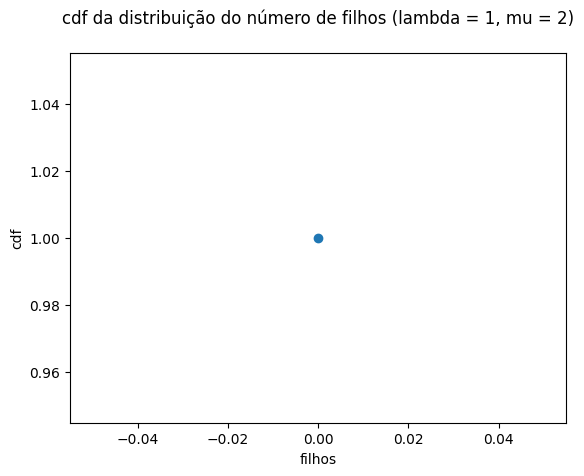

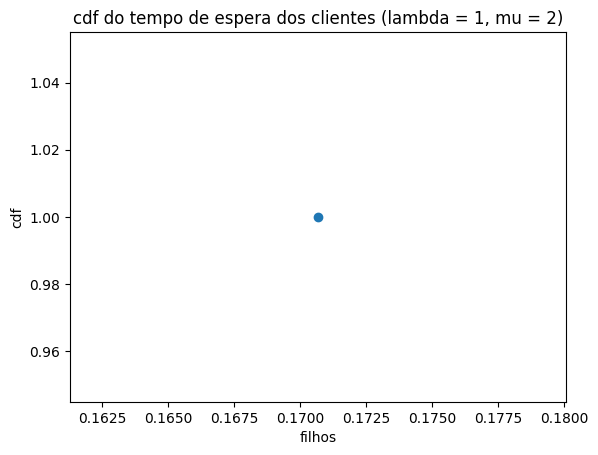

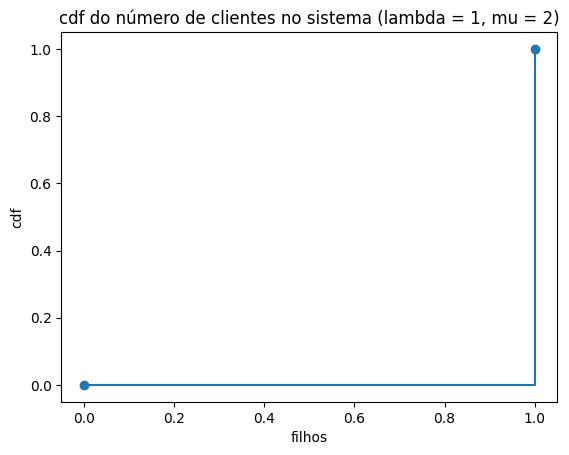

[<__main__.epidemic_simulation.<locals>.Measures at 0x7f8f7c76a560>,
 <__main__.epidemic_simulation.<locals>.Tree at 0x7f8f7c7697b0>,
 1,
 0.1706795896967808,
 2]

In [ ]:
epidemic_simulation(1, 2, 100000, DETERMINISTIC = False, VERBOSE = True)

Simulação com Lambda = 1 e tempo de serviço deterministíco = 0.5
Métricas obtidas:
E[N] =  1.470
E[T] =  0.735

Métricas da árvore

Frequência do número de filhos: : 
dict_items([(0, 1), (1, 1)])

Distribuição do número de filhos: 
dict_items([(0, 0.5), (1, 0.5)])

Esperança do número de filhos: 0.500 -- cenário subcrítico

CDF do número de filhos: 
{0: 0.5, 1: 1.0}

Grau saída raíz =  1
Grau saída máximo =  1.000
Altura árvore =  1.000
Média altura vértices =  0.500
Progenia = [1, 2]


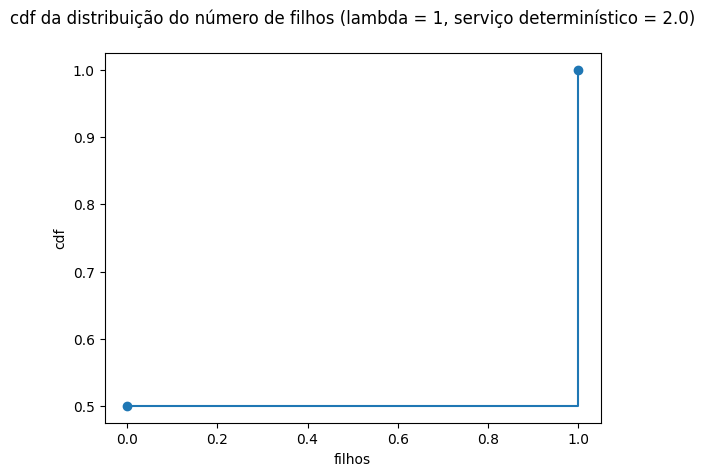

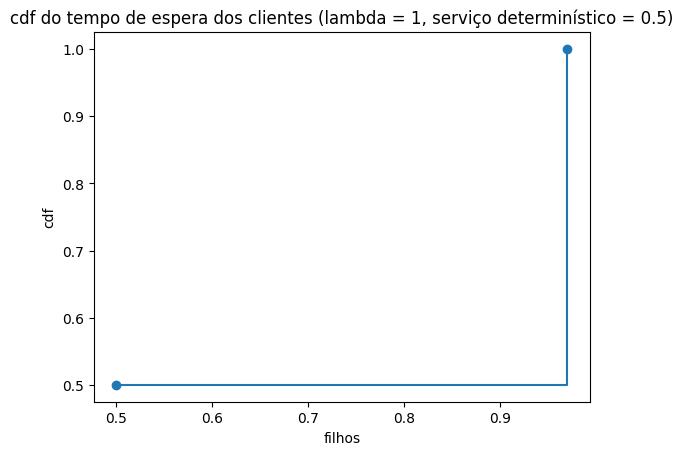

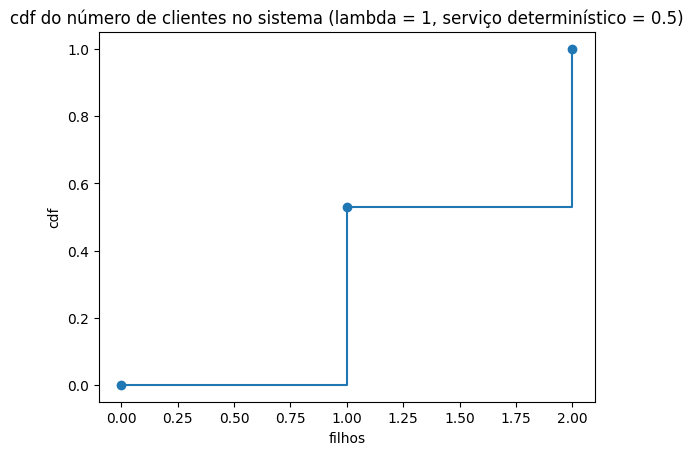

[<__main__.epidemic_simulation.<locals>.Measures at 0x7f8f7c6652a0>,
 <__main__.epidemic_simulation.<locals>.Tree at 0x7f8f7c665bd0>,
 1,
 1.0,
 4]

In [ ]:
epidemic_simulation(1, 1/2, 100000, DETERMINISTIC = True, VERBOSE = True)

Simulação com Lambda = 2 e Mu = 4
Métricas obtidas:
E[N] =  1.000
E[T] =  0.074

Métricas da árvore

Frequência do número de filhos: : 
dict_items([(0, 1)])

Distribuição do número de filhos: 
dict_items([(0, 1.0)])

Esperança do número de filhos: 0.000 -- cenário subcrítico

CDF do número de filhos: 
{0: 1.0}

Grau saída raíz =  0
Grau saída máximo =  0.000
Altura árvore =  0.000
Média altura vértices =  0.000
Progenia = [1]


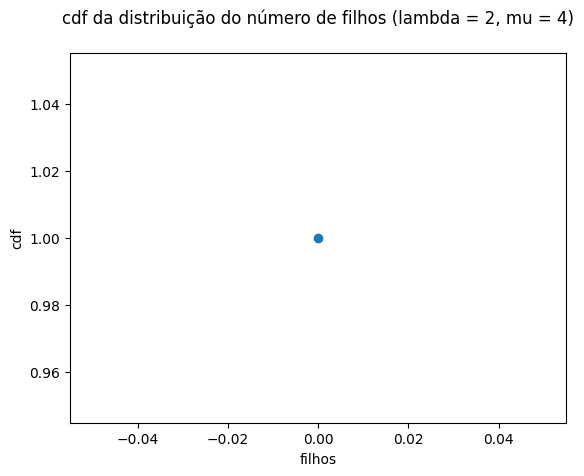

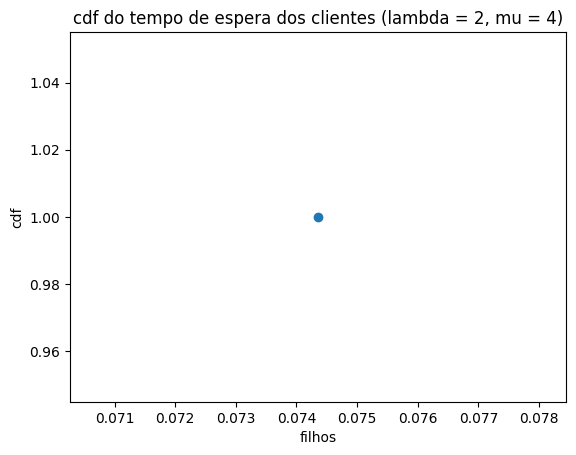

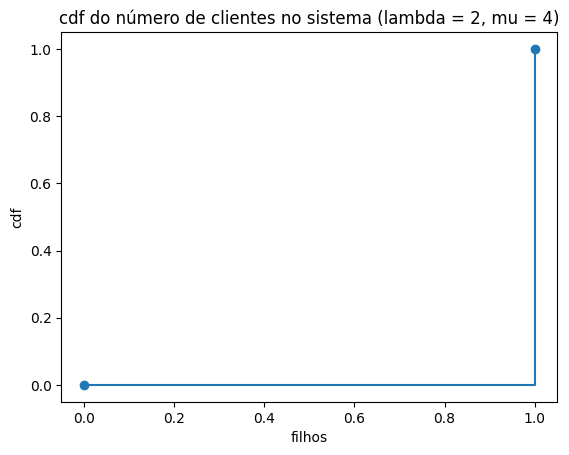

[<__main__.epidemic_simulation.<locals>.Measures at 0x7f8f623d9150>,
 <__main__.epidemic_simulation.<locals>.Tree at 0x7f8f623d9e10>,
 1,
 0.07435802075240157,
 2]

In [ ]:
epidemic_simulation(2, 4, 100000, DETERMINISTIC = False, VERBOSE = True)

Simulação com Lambda = 2 e tempo de serviço deterministíco = 0.25
Métricas obtidas:
E[N] =  1.000
E[T] =  0.250

Métricas da árvore

Frequência do número de filhos: : 
dict_items([(0, 1)])

Distribuição do número de filhos: 
dict_items([(0, 1.0)])

Esperança do número de filhos: 0.000 -- cenário subcrítico

CDF do número de filhos: 
{0: 1.0}

Grau saída raíz =  0
Grau saída máximo =  0.000
Altura árvore =  0.000
Média altura vértices =  0.000
Progenia = [1]


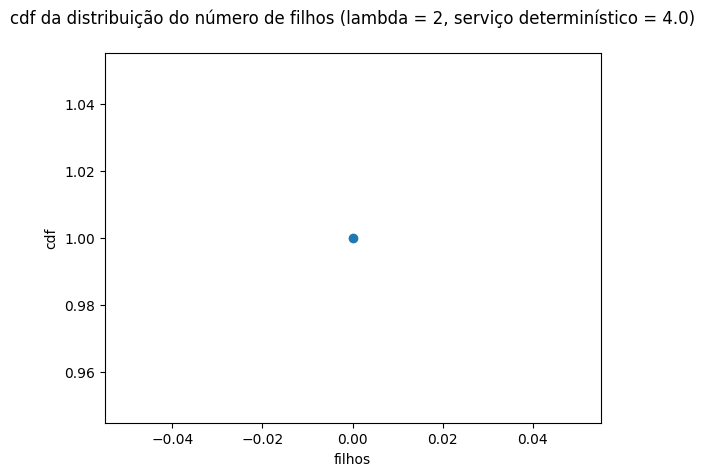

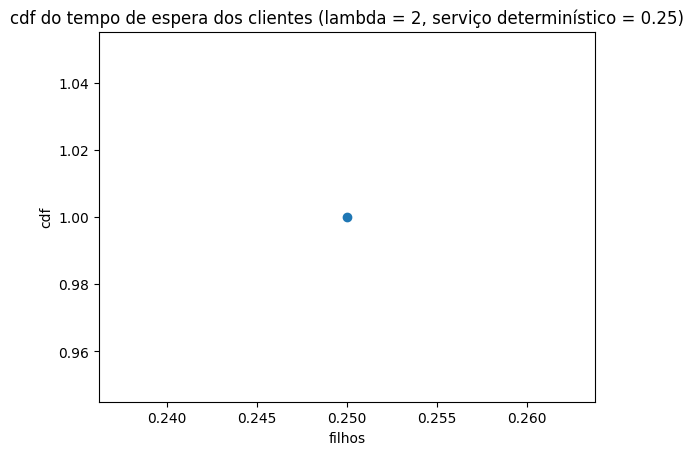

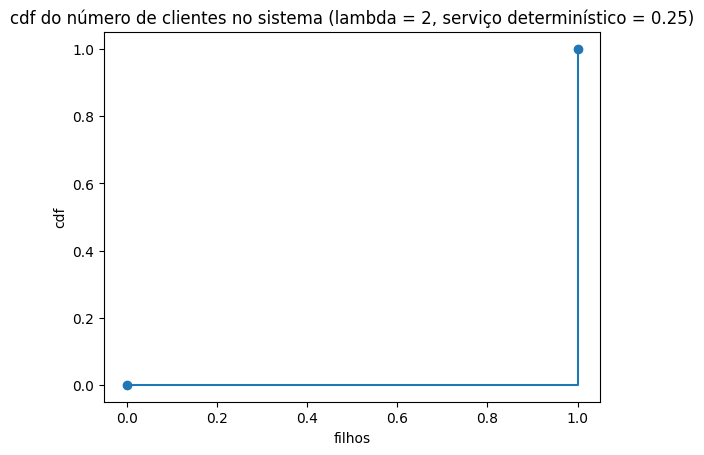

[<__main__.epidemic_simulation.<locals>.Measures at 0x7f8f9826c9d0>,
 <__main__.epidemic_simulation.<locals>.Tree at 0x7f8f9826f820>,
 1,
 0.25,
 2]

In [ ]:
epidemic_simulation(2, 1/4, 100000, DETERMINISTIC = True, VERBOSE = True)

Simulação com Lambda = 1.05 e Mu = 1
Métricas obtidas:
E[N] =  4.302
E[T] =  5.865

Métricas da árvore

Frequência do número de filhos: : 
dict_items([(0, 7), (1, 5), (2, 2), (5, 1)])

Distribuição do número de filhos: 
dict_items([(0, 0.467), (1, 0.333), (2, 0.133), (5, 0.067)])

Esperança do número de filhos: 0.934 -- cenário subcrítico

CDF do número de filhos: 
{0: 0.467, 1: 0.8, 2: 0.933, 5: 1.0}

Grau saída raíz =  2
Grau saída máximo =  5.000
Altura árvore =  4.000
Média altura vértices =  1.000
Progenia = [1, 3, 10, 19, 34]


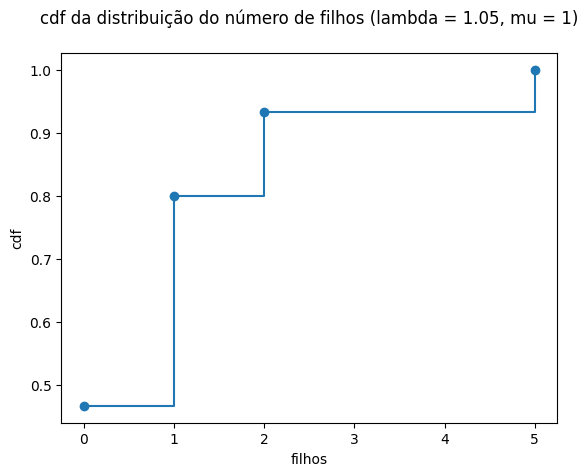

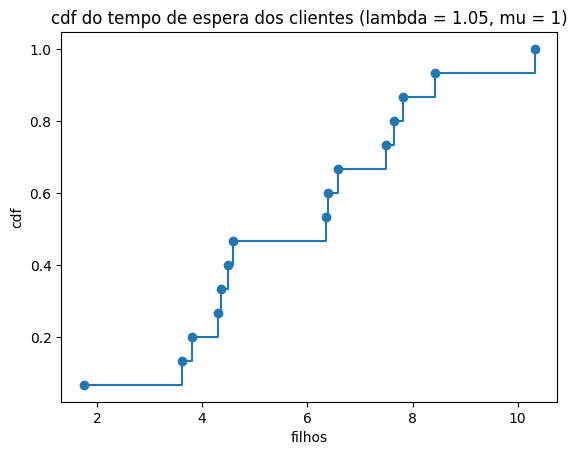

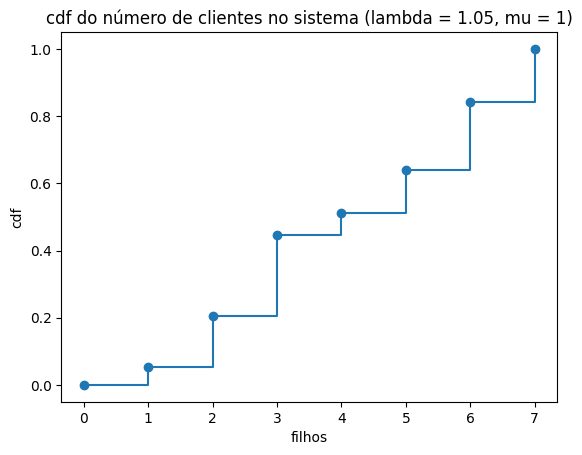

[<__main__.epidemic_simulation.<locals>.Measures at 0x7f8f981c3190>,
 <__main__.epidemic_simulation.<locals>.Tree at 0x7f8f981c1e70>,
 1,
 20.453090462114133,
 30]

In [ ]:
epidemic_simulation(1.05, 1, 100000, DETERMINISTIC = False, VERBOSE = True)

Simulação com Lambda = 1.05 e tempo de serviço deterministíco = 1.0
Métricas obtidas:
E[N] =  2.517
E[T] =  2.517

Métricas da árvore

Frequência do número de filhos: : 
dict_items([(0, 6), (1, 5), (2, 5)])

Distribuição do número de filhos: 
dict_items([(0, 0.375), (1, 0.312), (2, 0.312)])

Esperança do número de filhos: 0.936 -- cenário subcrítico

CDF do número de filhos: 
{0: 0.375, 1: 0.687, 2: 0.999}

Grau saída raíz =  2
Grau saída máximo =  2.000
Altura árvore =  8.000
Média altura vértices =  2.438
Progenia = [1, 3, 6, 13, 26, 50, 100, 201, 401]


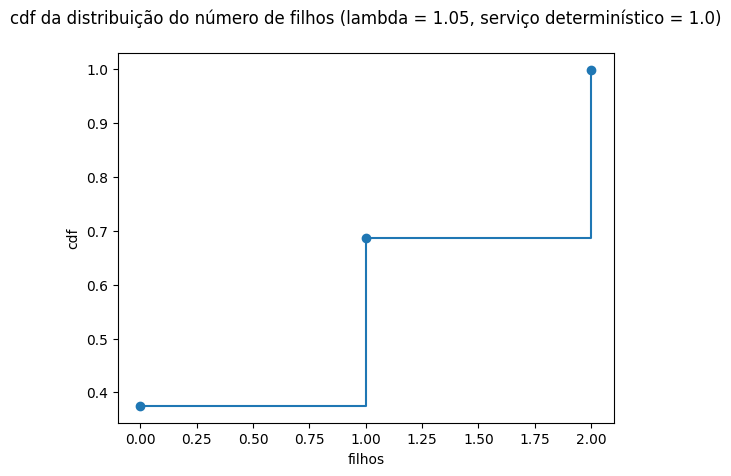

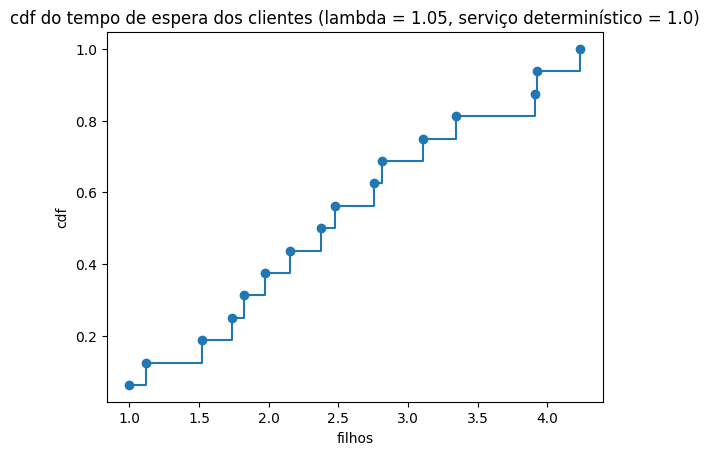

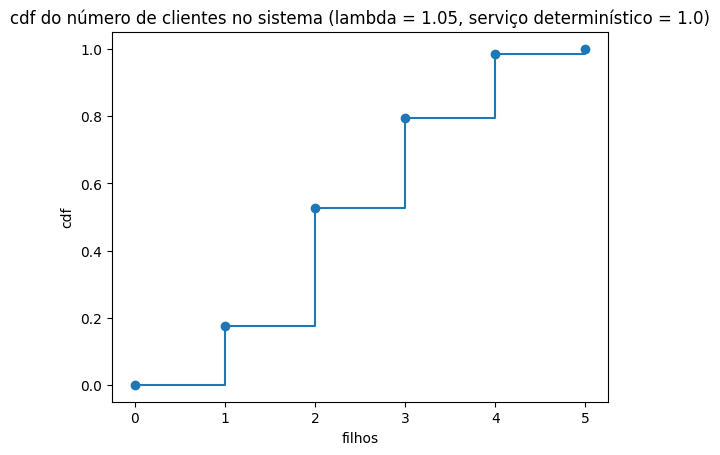

[<__main__.epidemic_simulation.<locals>.Measures at 0x7f8f620fbd60>,
 <__main__.epidemic_simulation.<locals>.Tree at 0x7f8f620fab30>,
 1,
 16.0,
 32]

In [ ]:
epidemic_simulation(1.05, 1/1, 100000, DETERMINISTIC = True, VERBOSE = True)

Simulação com Lambda = 1.1 e Mu = 1
Métricas obtidas:
E[N] =  1.084
E[T] =  0.519

Métricas da árvore

Frequência do número de filhos: : 
dict_items([(0, 1), (1, 1)])

Distribuição do número de filhos: 
dict_items([(0, 0.5), (1, 0.5)])

Esperança do número de filhos: 0.500 -- cenário subcrítico

CDF do número de filhos: 
{0: 0.5, 1: 1.0}

Grau saída raíz =  1
Grau saída máximo =  1.000
Altura árvore =  1.000
Média altura vértices =  0.500
Progenia = [1, 2]


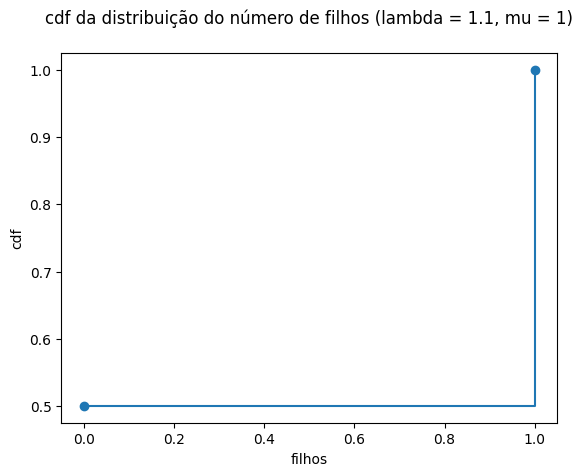

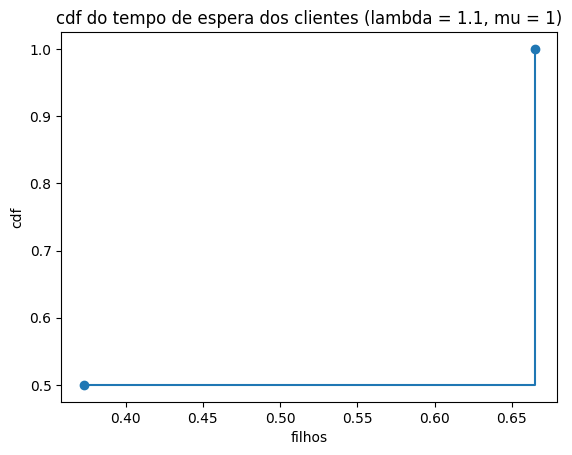

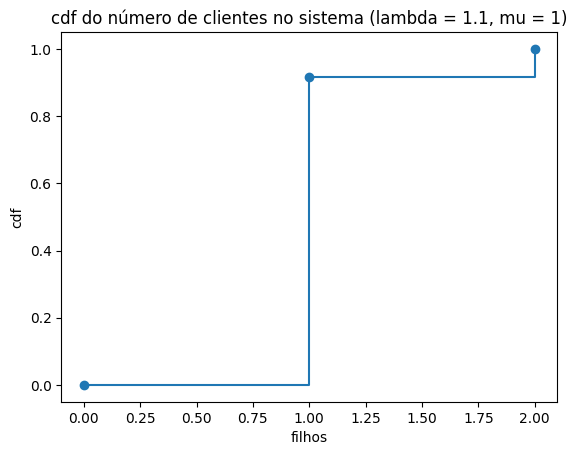

[<__main__.epidemic_simulation.<locals>.Measures at 0x7f8f981c3700>,
 <__main__.epidemic_simulation.<locals>.Tree at 0x7f8f981c00a0>,
 1,
 0.9574381817052051,
 4]

In [ ]:
epidemic_simulation(1.10, 1, 100000, DETERMINISTIC = False, VERBOSE = True)

Simulação com Lambda = 1.1 e tempo de serviço deterministíco = 1.0
Métricas obtidas:
E[N] =  1.518
E[T] =  1.518

Métricas da árvore

Frequência do número de filhos: : 
dict_items([(0, 1), (1, 4)])

Distribuição do número de filhos: 
dict_items([(0, 0.2), (1, 0.8)])

Esperança do número de filhos: 0.800 -- cenário subcrítico

CDF do número de filhos: 
{0: 0.2, 1: 1.0}

Grau saída raíz =  1
Grau saída máximo =  1.000
Altura árvore =  4.000
Média altura vértices =  2.000
Progenia = [1, 2, 4, 8, 16]


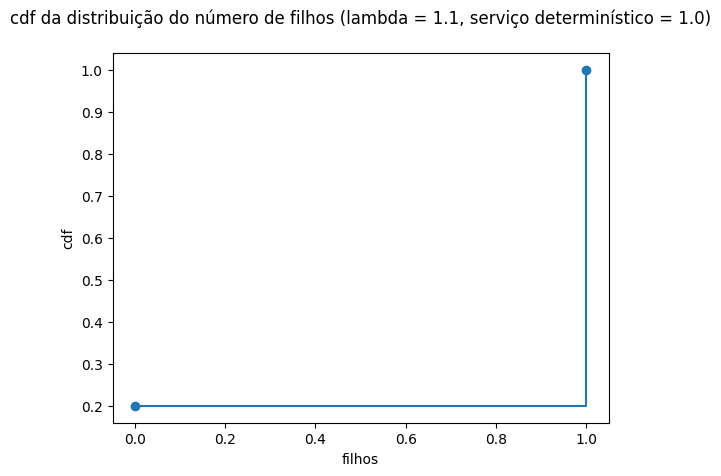

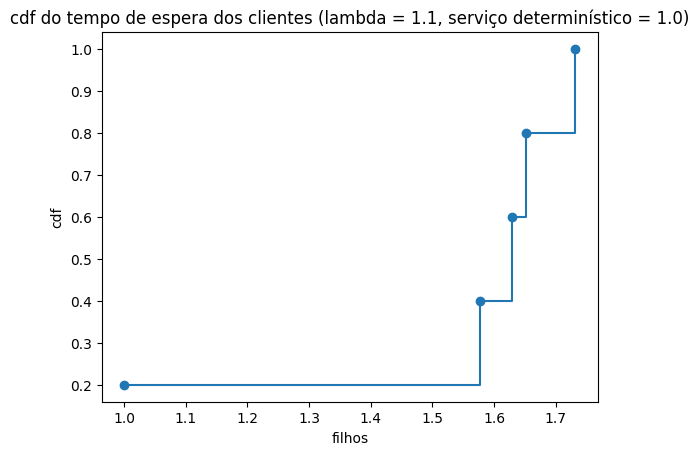

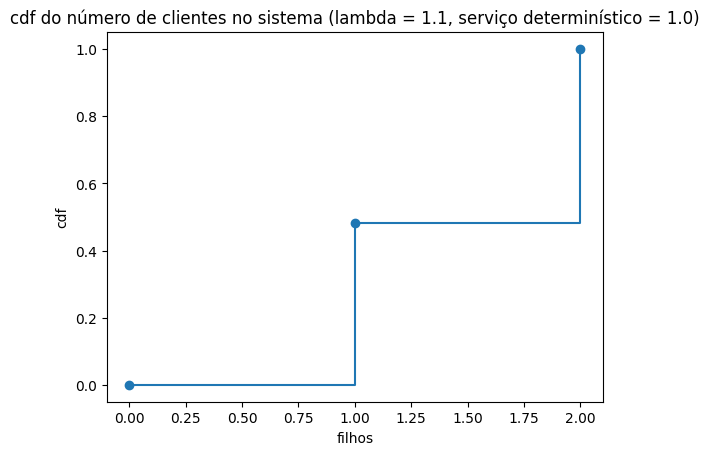

[<__main__.epidemic_simulation.<locals>.Measures at 0x7f8f5dbbb460>,
 <__main__.epidemic_simulation.<locals>.Tree at 0x7f8f5dbbbf10>,
 1,
 5.0,
 10]

In [ ]:
epidemic_simulation(1.10, 1/1, 100000, DETERMINISTIC = True, VERBOSE = True)

In [ ]:
def epidemic_experiment(LAMBDA, MU, DETERMINISTIC = False, COUNT_SIMULATIONS = 20, LIM_TIME = 1000000):

  averages = {"N": 0.0, "T" : 0.0, "root_out_degree": 0.0, "max_out_degree": 0.0, "tree_height":0.0, "nodes_height":0.0, "busy_period": 0.0, "count_nodes": 0.0, "epidemic_extinction_prob" : 0.0, "offspring_mean" : 0.0}
  variances = {"N": 0.0, "T" : 0.0, "root_out_degree": 0.0, "max_out_degree": 0.0, "tree_height":0.0, "nodes_height":0.0, "busy_period": 0.0, "count_nodes": 0.0, "epidemic_extinction_prob" : 0.0, "offspring_mean" : 0.0}
  std_dev = {"N": [], "T" : [], "root_out_degree": 0.0, "max_out_degree": 0.0, "tree_height":0.0, "nodes_height":0.0, "busy_period": 0.0, "count_nodes": 0.0, "epidemic_extinction_prob" : 0.0, "offspring_mean" : 0.0}
  results = {"N": [], "T" : [], "root_out_degree": [], "max_out_degree": [], "tree_height":[], "nodes_height":[], "busy_period": [], "count_nodes": [], "epidemic_extinction_prob" : [], "offspring_mean" : []}
  confidence_interval = {"N": [], "T" : [], "root_out_degree": [], "max_out_degree": [], "tree_height":[], "nodes_height":[], "busy_period": [], "count_nodes": [], "epidemic_extinction_prob" : [], "offspring_mean" : []}

  def calc_average(s):
    n = len(s)
    total = 0
    for x in s:
      total += x
    return total / n

  def calc_variance(s, average):
    n = len(s)
    if(n == 1):
      return 0.0
    total = 0
    for x in s:
      total += (x - average) ** 2
    return total / (n - 1)


  def calc_confidence_interval(t):
    return [averages[key] - t * std_dev[key] / ((COUNT_SIMULATIONS+1)**0.5), averages[key] + t * std_dev[key] / ((COUNT_SIMULATIONS+1)**0.5)]

  for sim in range(COUNT_SIMULATIONS):
    #print(f"Simulação {sim}:\n")
    measures, tree, gambler_ruin, T, P = epidemic_simulation(LAMBDA, MU, LIM_TIME, DETERMINISTIC)
    #measures
    results["N"].append(measures.Expected_Value_N())
    results["T"].append(measures.Expected_Value_T())
    #tree
    results["root_out_degree"].append(len(tree.children[tree.root]))
    results["max_out_degree"].append(tree.max_out_degree)
    results["tree_height"].append(tree.height[tree.root])
    results["nodes_height"].append(tree.E_height_nodes())
    results["busy_period"].append(T)
    results["count_nodes"].append(tree.n)
    if(gambler_ruin == 1):
      results["epidemic_extinction_prob"].append(1)
    else:
      results["epidemic_extinction_prob"].append(0)
    results["offspring_mean"].append(tree.offspring_mean)



  for key, value in averages.items():
    averages[key] /= COUNT_SIMULATIONS

    for key, value in results.items():
      averages[key] = calc_average(value)
      variances[key] = calc_variance(value, averages[key])
      std_dev[key] = variances[key] ** (1/2)
      confidence_interval[key] = calc_confidence_interval(T)

  if(DETERMINISTIC):
    print(f"Experimento com Lambda = {LAMBDA} e tempo de serviço deterministíco = {MU}")
  else:
    print(f"Experimento com Lambda = {LAMBDA} e Mu = {MU}")

  print("\nResultado:\n")

  for key, value in results.items():
      print(f" {key} média {averages[key]:.3f} | variancia {std_dev[key]*std_dev[key]:.3f} | IC: ({confidence_interval[key][0]:.3f}, {confidence_interval[key][1]:.3f}) | Média +- desvio: ({averages[key] - std_dev[key]:.3f}, {averages[key] + std_dev[key]:.3f})")

  #print(averages)


In [ ]:
epidemic_experiment(1, 2, False)

Experimento com Lambda = 1 e Mu = 2

Resultado:

 N média 1.166 | variancia 0.093 | IC: (1.165, 1.166) | Média +- desvio: (0.860, 1.471)
 T média 0.440 | variancia 0.107 | IC: (0.439, 0.440) | Média +- desvio: (0.113, 0.766)
 root_out_degree média 0.550 | variancia 0.682 | IC: (0.548, 0.552) | Média +- desvio: (-0.276, 1.376)
 max_out_degree média 0.550 | variancia 0.682 | IC: (0.548, 0.552) | Média +- desvio: (-0.276, 1.376)
 tree_height média 0.650 | variancia 1.292 | IC: (0.647, 0.653) | Média +- desvio: (-0.487, 1.787)
 nodes_height média 0.277 | variancia 0.232 | IC: (0.276, 0.278) | Média +- desvio: (-0.205, 0.758)
 busy_period média 0.763 | variancia 1.011 | IC: (0.760, 0.765) | Média +- desvio: (-0.243, 1.768)
 count_nodes média 1.850 | variancia 2.134 | IC: (1.847, 1.853) | Média +- desvio: (0.389, 3.311)
 epidemic_extinction_probability média 1.000 | variancia 0.000 | IC: (1.000, 1.000) | Média +- desvio: (1.000, 1.000)
 offspring_mean média 0.232 | variancia 0.110 | IC: (0.2

In [ ]:
epidemic_experiment(1, 1/2, True)

Experimento com Lambda = 1 e tempo de serviço deterministíco = 0.5

Resultado:

 N média 1.222 | variancia 0.098 | IC: (1.188, 1.256) | Média +- desvio: (0.909, 1.535)
 T média 0.611 | variancia 0.024 | IC: (0.594, 0.628) | Média +- desvio: (0.455, 0.767)
 root_out_degree média 0.650 | variancia 0.661 | IC: (0.561, 0.739) | Média +- desvio: (-0.163, 1.463)
 max_out_degree média 0.650 | variancia 0.661 | IC: (0.561, 0.739) | Média +- desvio: (-0.163, 1.463)
 tree_height média 0.700 | variancia 0.958 | IC: (0.593, 0.807) | Média +- desvio: (-0.279, 1.679)
 nodes_height média 0.302 | variancia 0.169 | IC: (0.257, 0.346) | Média +- desvio: (-0.109, 0.712)
 busy_period média 0.975 | variancia 0.513 | IC: (0.897, 1.053) | Média +- desvio: (0.259, 1.691)
 count_nodes média 1.950 | variancia 2.050 | IC: (1.794, 2.106) | Média +- desvio: (0.518, 3.382)
 epidemic_extinction_probability média 1.000 | variancia 0.000 | IC: (1.000, 1.000) | Média +- desvio: (1.000, 1.000)
 offspring_mean média 0.28

In [ ]:
epidemic_experiment(2, 4, False)

Experimento com Lambda = 2 e Mu = 4

Resultado:

 N média 1.098 | variancia 0.046 | IC: (1.098, 1.099) | Média +- desvio: (0.885, 1.312)
 T média 0.181 | variancia 0.023 | IC: (0.181, 0.181) | Média +- desvio: (0.028, 0.333)
 root_out_degree média 0.300 | variancia 0.326 | IC: (0.299, 0.301) | Média +- desvio: (-0.271, 0.871)
 max_out_degree média 0.350 | variancia 0.450 | IC: (0.349, 0.351) | Média +- desvio: (-0.321, 1.021)
 tree_height média 0.400 | variancia 0.674 | IC: (0.399, 0.401) | Média +- desvio: (-0.421, 1.221)
 nodes_height média 0.177 | variancia 0.128 | IC: (0.176, 0.177) | Média +- desvio: (-0.181, 0.534)
 busy_period média 0.287 | variancia 0.121 | IC: (0.287, 0.288) | Média +- desvio: (-0.061, 0.636)
 count_nodes média 1.500 | variancia 1.105 | IC: (1.499, 1.501) | Média +- desvio: (0.449, 2.551)
 epidemic_extinction_probability média 1.000 | variancia 0.000 | IC: (1.000, 1.000) | Média +- desvio: (1.000, 1.000)
 offspring_mean média 0.157 | variancia 0.081 | IC: (0.1

In [ ]:
epidemic_experiment(2, 1/4, True)

Experimento com Lambda = 2 e tempo de serviço deterministíco = 0.25

Resultado:

 N média 1.175 | variancia 0.143 | IC: (1.133, 1.216) | Média +- desvio: (0.797, 1.552)
 T média 0.294 | variancia 0.009 | IC: (0.283, 0.304) | Média +- desvio: (0.199, 0.388)
 root_out_degree média 0.450 | variancia 0.471 | IC: (0.375, 0.525) | Média +- desvio: (-0.236, 1.136)
 max_out_degree média 0.450 | variancia 0.471 | IC: (0.375, 0.525) | Média +- desvio: (-0.236, 1.136)
 tree_height média 0.550 | variancia 0.787 | IC: (0.453, 0.647) | Média +- desvio: (-0.337, 1.437)
 nodes_height média 0.235 | variancia 0.133 | IC: (0.196, 0.275) | Média +- desvio: (-0.129, 0.599)
 busy_period média 0.450 | variancia 0.168 | IC: (0.405, 0.495) | Média +- desvio: (0.040, 0.860)
 count_nodes média 1.800 | variancia 2.695 | IC: (1.621, 1.979) | Média +- desvio: (0.158, 3.442)
 epidemic_extinction_probability média 1.000 | variancia 0.000 | IC: (1.000, 1.000) | Média +- desvio: (1.000, 1.000)
 offspring_mean média 0.2

In [ ]:
epidemic_experiment(1.05, 1, False)

Experimento com Lambda = 1.05 e Mu = 1

Resultado:

 N média 3726.272 | variancia 82699885.409 | IC: (1936.078, 5516.465) | Média +- desvio: (-5367.676, 12820.220)
 T média 3375.599 | variancia 67874827.659 | IC: (1753.782, 4997.417) | Média +- desvio: (-4863.019, 11614.217)
 root_out_degree média 1.350 | variancia 4.239 | IC: (0.945, 1.755) | Média +- desvio: (-0.709, 3.409)
 max_out_degree média 4.550 | variancia 52.892 | IC: (3.118, 5.982) | Média +- desvio: (-2.723, 11.823)
 tree_height média 26.300 | variancia 3021.484 | IC: (15.479, 37.121) | Média +- desvio: (-28.668, 81.268)
 nodes_height média 0.764 | variancia 1.230 | IC: (0.546, 0.982) | Média +- desvio: (-0.345, 1.873)
 busy_period média 150066.610 | variancia 134189664875.645 | IC: (77954.690, 222178.530) | Média +- desvio: (-216252.465, 516385.685)
 count_nodes média 157599.850 | variancia 148006654199.713 | IC: (81866.329, 233333.371) | Média +- desvio: (-227116.480, 542316.180)
 epidemic_extinction_probability média 0.8

In [ ]:
epidemic_experiment(1.05, 1/1, True)

Experimento com Lambda = 1.05 e tempo de serviço deterministíco = 1.0

Resultado:

 N média 3.093 | variancia 31.079 | IC: (-15.155, 21.341) | Média +- desvio: (-2.482, 8.668)
 T média 3.093 | variancia 31.079 | IC: (-15.155, 21.341) | Média +- desvio: (-2.482, 8.668)
 root_out_degree média 1.000 | variancia 1.053 | IC: (-2.358, 4.358) | Média +- desvio: (-0.026, 2.026)
 max_out_degree média 1.600 | variancia 2.989 | IC: (-4.060, 7.260) | Média +- desvio: (-0.129, 3.329)
 tree_height média 8.250 | variancia 251.566 | IC: (-43.667, 60.167) | Média +- desvio: (-7.611, 24.111)
 nodes_height média 1.486 | variancia 3.513 | IC: (-4.649, 7.621) | Média +- desvio: (-0.388, 3.360)
 busy_period média 73.350 | variancia 67708.450 | IC: (-778.382, 925.082) | Média +- desvio: (-186.858, 333.558)
 count_nodes média 73.350 | variancia 67708.450 | IC: (-778.382, 925.082) | Média +- desvio: (-186.858, 333.558)
 epidemic_extinction_probability média 1.000 | variancia 0.000 | IC: (1.000, 1.000) | Média 

In [ ]:
epidemic_experiment(1.10, 1, False)

Experimento com Lambda = 1.1 e Mu = 1

Resultado:

 N média 10017.304 | variancia 422405342.731 | IC: (-4484914595.813, 4484934630.421) | Média +- desvio: (-10535.198, 30569.806)
 T média 8277.471 | variancia 288415417.975 | IC: (-3705942805.906, 3705959360.847) | Média +- desvio: (-8705.327, 25260.268)
 root_out_degree média 1.200 | variancia 1.642 | IC: (-279633.423, 279635.823) | Média +- desvio: (-0.081, 2.481)
 max_out_degree média 5.500 | variancia 71.737 | IC: (-1848248.154, 1848259.154) | Média +- desvio: (-2.970, 13.970)
 tree_height média 23.100 | variancia 2033.674 | IC: (-9840792.196, 9840838.396) | Média +- desvio: (-21.996, 68.196)
 nodes_height média 0.699 | variancia 0.640 | IC: (-174574.631, 174576.030) | Média +- desvio: (-0.101, 1.499)
 busy_period média 200002.859 | variancia 168420074868.605 | IC: (-89554291878.823, 89554691884.541) | Média +- desvio: (-210387.290, 610393.009)
 count_nodes média 220075.350 | variancia 203921271630.871 | IC: (-98541856839.944, 98542

In [ ]:
epidemic_experiment(1.10, 1/1, True)

Experimento com Lambda = 1.1 e tempo de serviço deterministíco = 1.0

Resultado:

 N média 15126.528 | variancia 562086042.061 | IC: (-394.233, 30647.289) | Média +- desvio: (-8581.826, 38834.882)
 T média 12484.420 | variancia 382815302.092 | IC: (-324.316, 25293.155) | Média +- desvio: (-7081.247, 32050.086)
 root_out_degree média 1.200 | variancia 0.800 | IC: (0.614, 1.786) | Média +- desvio: (0.306, 2.094)
 max_out_degree média 3.400 | variancia 13.305 | IC: (1.012, 5.788) | Média +- desvio: (-0.248, 7.048)
 tree_height média 35.000 | variancia 2500.737 | IC: (2.262, 67.738) | Média +- desvio: (-15.007, 85.007)
 nodes_height média 1.529 | variancia 2.222 | IC: (0.553, 2.504) | Média +- desvio: (0.038, 3.019)
 busy_period média 300016.700 | variancia 221042088817.274 | IC: (-7769.466, 607802.866) | Média +- desvio: (-170134.434, 770167.834)
 count_nodes média 330233.600 | variancia 267814428416.147 | IC: (-8554.848, 669022.048) | Média +- desvio: (-187274.302, 847741.502)
 epidemic_